# Phoneme Recognition

**Problem Statement:** Phoneme Classification in Speech Recognition

**Domain:** Speech Recognition

**Objective:** Develop a deep learning-based model to classify phonemes in human speech.

**Task Description:** Given an audio input of human speech, the task is to classify each 25ms frame of the audio into one of the 71 possible phonemes, which are the fundamental, indivisible units of human speech. This is akin to classifying individual letters in written English.

**Challenges:**
Temporal Nature of Audio: Speech is a continuous signal, and phoneme boundaries may not align perfectly with frame boundaries.
Class Imbalance: Some phonemes are more frequent than others, making it necessary to handle imbalanced data.
Acoustic Variability: Variability in speakers, accents, and background noise adds complexity to the classification task.

**Success Metric:**
The model’s performance will be evaluated using metrics such as classification accuracy, and confusion matrix analysis on a test set representing diverse speech patterns.

**Context**

**Preparing audio data for phoneme classification**

**Classifying Phonemes**

**More on Objective**



## Setup/Importing

In [2]:
# Connect this notebook to Google Drive https://colab.research.google.com/notebooks/io.ipynb
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not on google drive")

Mounted at /content/drive


In [3]:
# Change directories ("cd") to the folder containing the Notebook
%cd /content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/

/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme


In [3]:
############  Not needed ########################################################
!cp "/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/utils.py" .

############  Not needed ########################################################
# Note, this is not needed as the data is locally hosted in /content/drive/My Drive/Data/Phoneme/data
# If data needs to be downloaded from a S3 location on Amazon AWS
!wget -P /content/drive/MyDrive/pa1b/ https://cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com/colab/pa1b/data1pb.zip
#Then, unzip the data from Amazon AWS to local Drive
!unzip /content/drive/MyDrive/pa1b/data1pb.zip


cp: '/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/utils.py' and './utils.py' are the same file
^C
--2025-01-06 22:33:31--  https://cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com/colab/pa1b/data1pb.zip
Resolving cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com (cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com)... 3.5.132.126, 52.219.176.210, 3.5.129.15, ...
Connecting to cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com (cmu-dele-leaderboard-us-east-2-003014019879.s3.us-east-2.amazonaws.com)|3.5.132.126|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8917643877 (8.3G) [application/zip]
Saving to: ‘/content/drive/MyDrive/pa1b/data1pb.zip’

data1pb.zip           3%[                    ] 289.49M  30.3MB/s    eta 4m 44s ^C
Archive:  /content/drive/MyDrive/pa1b/data1pb.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it

In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm.notebook import tqdm

import os

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Auto-detect if GPU is available

In [5]:
# Automatically detect if GPU is available.
# Output set to 'cuda' to use GPU acceleration; else output set to 'cpu'
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


# Section1: `Dataset`/`DataLoader`

When working with any dataset in `torch`, we'd almost always work with a `Dataset` and `DataLoader` object. Here's an overview of what they do:

`torch.utils.data.Dataset`
- Stores dataset (usually a single tensor or list of tensors) inside the object
    - Happens in `__init__()` function
- Defines how many observations are in the dataset
    - In `__len__()`
- Defines how to retrieve a single observation from the dataset given its index from 0 inclusive to `__len__()` exclusive
    - In `__getitem__()`


`torch.utils.data.DataLoader`
- Queries and batches observations from an initialized `Dataset`
- If `shuffle=True`, shuffles dataset for you every epoch (do this for training, not validation / testing)
- Handles basic multiprocessing

Some specialized datasets usually need a custom `Dataset` class. However, for popular datasets, there are often existing implementations, like those found [here](https://pytorch.org/vision/stable/datasets.html).

## Initialize a customized Dataset


In [6]:
from utils import num_ms

# Specify the desired number of context frames to concatenate to each side of target
# Then, preview how many milliseconds will be covered with selected `k`
k = 42
print(f"# milliseconds covered with context {k}:", num_ms(k))

# milliseconds covered with context 42: 875


In [7]:
# Initialize dataset objects for training, validation, and testing.
from utils import KContextSpectrograms

train_dataset = KContextSpectrograms("/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/train.npy", "/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/train_labels.npy", k=42)
val_dataset = KContextSpectrograms("/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/val.npy", "/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/val_labels.npy", k=42)
test_dataset = KContextSpectrograms("/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/test.npy", k=42)

print(f"Number of frames in training dataset: {train_dataset.total_frames}")

print(f"Number of frames in validation dataset: {val_dataset.total_frames}")

print(f"Number of frames in testing dataset: {test_dataset.total_frames}")

# Print the shape of the data for the first few frames and utterances
print(f"Shape of data for the first frame in the first utterance: {train_dataset[0][0].shape}")





Details for /content/drive/My Drive/Data/Phoneme/data/train.npy is below:
	Number of utterances: (14542,)

Details for /content/drive/My Drive/Data/Phoneme/data/val.npy is below:
	Number of utterances: (2200,)

Details for /content/drive/My Drive/Data/Phoneme/data/test.npy is below:
	Number of utterances: (2200,)
Number of frames in training dataset: 18482968
Number of frames in validation dataset: 1559057
Number of frames in testing dataset: 1618835
Shape of data for the first frame in the first utterance: torch.Size([3400])


## Initialize DataLoaders
Although `Dataset`s frequently need custom implementations, `DataLoader`s are usually standard.

Used [this documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) to implement the following:

- Specify an adequate batch size (see writeup)
- Initialize training dataloader with batch size, pinned memory, number of workers, and with shuffling.
- Initialize validation dataloader and test dataloader with your batch size, pinned memory, number of workers, and WITHOUT shuffling.
    - We don't shuffle val because we're just calculating the accuracy on every observation, so shuffling just slows things down without mattering
    - We don't shuffle test because we need to export our predictions in the correct order
    - We use num_workers equal to cpu count to prepare data in parallel
    - We pin memory to speed up data transfer

For examples of initializing `Dataset`s/`DataLoader`s, see [here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html).

In [8]:
# Specify how many observations should go in each batch
batch_size = 1024

# pass num_workers into each dataloader
num_workers = os.cpu_count()

print(f'Num of workers:  {num_workers}')

# Initialize `Dataloader` objects for training, validation, and testing.
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

Num of workers:  2


# Section2: Training/Validation/Prediction Routines


In [9]:
def train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, patience=3):
    """[Given] Trains and validates network for `num_epochs`

    Args:
        model (nn.Sequential): Initialized network, stored in an `nn.Sequential` object.
        optimizer (optim.Optimizer): Initialized optimizer like `optim.SGD` or `optim.Adam`
        scheduler (optim.lr_scheduler): Initialized scheduler like `optim.lr_scheduler.ReduceLROnPlateau` (or None)
        train_dataloader (torch.utils.data.DataLoader): Initialized training dataloader
        val_dataloader (torch.utils.data.DataLoader): Initialized validation dataloader
        num_epochs (int): # epochs to train for
    Returns:
        list, list: losses is the loss per every batch, val_accuracies is the val accuracy per epoch
    """
    losses = []
    val_accuracies = []

    # Early stopping
    best_val_accuracy = 0
    epochs_without_improvement = 0
    best_model_state = None

    for e in range(num_epochs):
        # No need to manually reshuffle; `Dataloader` handles that
        # Train model for one epoch
        epoch_losses = train_epoch(model, optimizer, train_dataloader, scheduler)
        losses.extend(epoch_losses)

        # Evaluate model on validation set, track accuracy
        val_accuracy = validate(model, val_dataloader)
        print(100 * val_accuracy)
        val_accuracies.append(val_accuracy)

        # Early stopping
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_without_improvement = 0
            # Save the best model state
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        else:
            epochs_without_improvement += 1
            print(f'Epochs without improvement: {epochs_without_improvement}/{patience}')

        # Stop if no improvement for 'patience' epochs
        if epochs_without_improvement >= patience:
            print(f'\nEarly stopping triggered after epoch {e+1}')
            print(f'Best validation accuracy: {100 * best_val_accuracy:.2f}%')
            # Restore best model
            model.load_state_dict(best_model_state)
            break

    return losses, val_accuracies

In [10]:
def validate(model, dataloader):
    """[Given] Evaluates network and calculates accuracy for a full validation dataset.

    Args:
        model (nn.Sequential): Your initialized network, stored in a `Sequential` object.
        dataloader (torch.utils.data.DataLoader): Initialized validation dataloader

    Returns:
        float: Accuracy rate for entire val set.
    """
    # Set model to evaluate mode (train mode is `.train()`)
    model.eval()

    total_correct = 0
    # Run loop with `tqdm` progress bar
    for i, (data, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        # Put tensors on specified device (GPU or CPU)
        data, labels = data.to(DEVICE), labels.to(DEVICE)
        logits = model(data)
        num_correct = (logits.argmax(axis=1) == labels).cpu().numpy().sum()
        total_correct += num_correct
    return total_correct / len(dataloader.dataset)

## `train_epoch()`

Now to write the training routine of a single epoch.

See the `validate()` method especially for hints, section 4 [here](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) is also a good reference.

```
def train_epoch():
    set_model_to_train_mode()
    loss_function = create_loss_function_object() # cross entropy!
    for (data, labels) in tqdm(dataloader):
        data, labels = put_tensors_on_appropriate_device(DEVICE, data, labels) # See val method for hint
        reset_gradients_to_zero()
        logits = forward_pass_through_model(model, data)
        loss = loss_function(logits, labels)
        run_backprop() # look up how torch does this; it's slightly different from what you did in part A
        update_model_params() # using the optimizer
        store_loss_value(loss)
    return loss_values
```

In [11]:
def train_epoch(model, optimizer, dataloader, scheduler=None):
    """Train model for one epoch.

    Args:
        model (nn.Sequential): Initialized network, stored in a `nn.Sequential` object.
        optimizer (optim.Optimizer): Initialized optimizer like `optim.SGD` or `optim.Adam`
        dataloader (torch.utils.data.DataLoader): Initialized training dataloader
        scheduler (optim.lr_scheduler): Optional scheduler if you want it


    Returns:
        list: Loss value of each batch for this epoch.
    """
    loss_per_batch = []                                   # Append loss values to this list
    model.train()                                         # Set Model to Train Mode
    loss_function = nn.CrossEntropyLoss()                 # Cross Entropy Loss

    # Run loop with `tqdm` progress bar
    for i, (data, labels) in tqdm(enumerate(dataloader), total=len(dataloader)):
        data, labels = data.to(DEVICE), labels.to(DEVICE) # Put tensors on appropriate device
        optimizer.zero_grad()                             # Reset gradients to zero
        logits = model(data)                              # Forward pass through the model
        loss = loss_function(logits, labels)              # Compute loss function
        loss.backward()                                   # Run back-propagation
        optimizer.step()                                  # Update the network params

        loss_per_batch.append(loss.item())                # Store the loss value for the batch

    # If scheduler, determine if we should change LR based on some metric
    if scheduler is not None:
        scheduler.step(sum(loss_per_batch)) # This assumes ReduceLROnPlateau; the choice of using sum is fairly arbitrary.

    return loss_per_batch

## `predict()`

This method is very similar to the `validate()` method. It's used to generate predictions for all observations in the test dataset.

You can assume that the dataloader is NOT shuffled. Each batch we receive will have `batch_size` number of observations (no labels), and we want to `extend` a list containing your previous predictions. The end result will be a 1-dimensional list containing integers, the same length as the test dataset.

In [2]:
def predict(model, dataloader, test_data_csv_path):
    """Generates predictions for the test dataset.

    Args:
        model (nn.Sequential): Your initialized network, stored in a `Sequential` object.
        dataloader (torch.utils.data.DataLoader): Initialized test dataloader

    Returns:
        list: should be same length as test dataset, and containing ints (or numpy integers)
    """
    pass

    model.eval()

    # Read true labels from test_results CSV
    df = pd.read_csv(test_data_csv_path)
    true_labels = df['label'].tolist()

    preds = []              # Store predictions
    with torch.no_grad():   # Turn off gradient calculatiins
      for i, data in tqdm(enumerate(dataloader), total=len(dataloader)):
          data = data.to(DEVICE)
          # Get the logits from the model, get batched predictions from logits, extend preds list with them
          logits = model(data)
          predicted = logits.argmax(axis=1)
          preds.extend(predicted.cpu().tolist())
          #preds.extend([predicted])

     # Ensure predictions and true labels have the same length
    assert len(preds) == len(true_labels), "Mismatch in number of predictions and true labels"
    return preds, true_labels


# Section3: Training

Initialize model, optimizer and loss function to begin training

In [13]:
num_phonemes = 71                        # Number of phonemes as specified in Background from Writeup
k = 42                                   # Number of context frames
flattened_input_size = 40 * (2 * k + 1)  # Each audio clip appears to have num_freqs dimension of size 40
                                         # Also, matches, shape of each train observation: torch.Size([x]), 40 features per frame

# Initialize model
model = nn.Sequential(
    nn.Linear(flattened_input_size, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.BatchNorm1d(1024),
    nn.ReLU(),
    nn.Linear(1024, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, num_phonemes)  # Output layer with `num_phonemes` outputs.
)

# Put model on `DEVICE`
model = model.to(DEVICE)

# Initialize optimizer
learning_rate = 0.001
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Initialize StepLR scheduler
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Initialize ReduceLROnPlateau scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # 'min' because we want to minimize validation loss
    factor=0.1,          # Reduce the learning rate by multiplying by this factor
    patience=5,          # Number of epochs to wait before reducing LR
)


In [14]:
# Call training routine for some epochs (train)
num_epochs = 10
losses, val_accuracies = train(model, optimizer, scheduler, train_dataloader, val_dataloader, num_epochs, patience=3)

  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

72.74820612716533


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.66844188506258


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.65016160409786
Epochs without improvement: 1/3


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.69576609450456


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.37364830150534
Epochs without improvement: 1/3


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.23766866766258
Epochs without improvement: 2/3


  0%|          | 0/18050 [00:00<?, ?it/s]

  0%|          | 0/1523 [00:00<?, ?it/s]

73.05460929266859
Epochs without improvement: 3/3

Early stopping triggered after epoch 7
Best validation accuracy: 73.70%


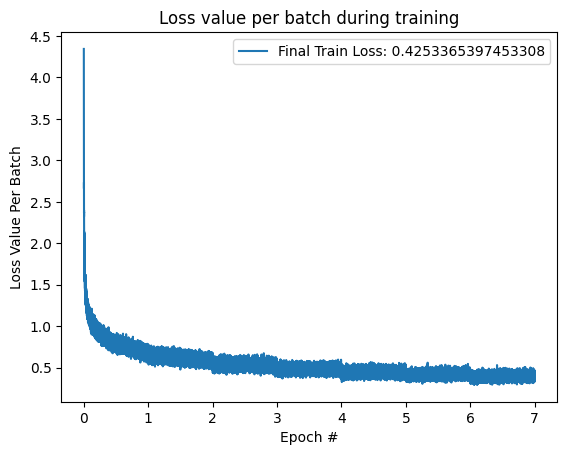

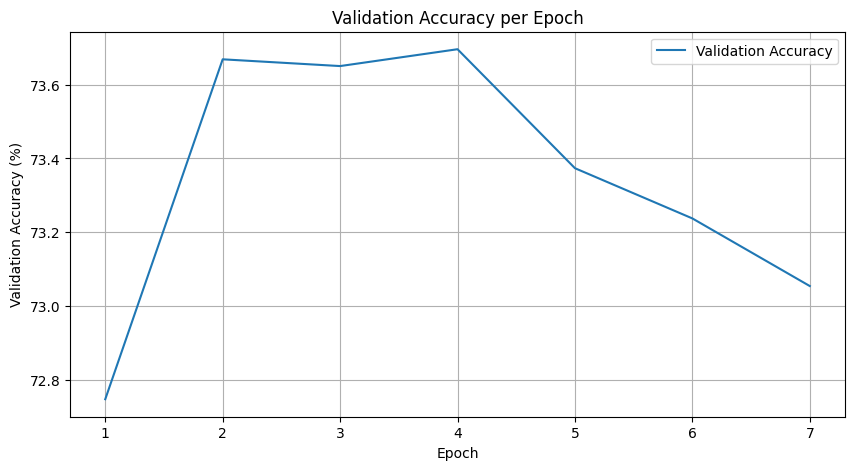

In [17]:
# Plot your training loss progress and validation accuracies
from utils import plot_loss, plot_val_accuracy

plot_loss(losses, num_batches=len(train_dataloader), num_epochs=7)
plot_val_accuracy(val_accuracies, num_epochs=7)

# Section4: Predict Test Dataset and Submission

Generates an output file in the `submissions/` folder with a timestamp

**NOTE:** The first row of the CSV can look like this:

`Id,Category`

In [3]:
test_results_csv_path = "/content/drive/My Drive/Colab Notebooks/DeepLearning_Phoneme/data/phoneme_labels_for_test_data.csv"
preds, true_labels = predict(model, test_dataloader, test_results_csv_path)

# Calculate Prediction accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(true_labels, preds)
print(f"Accuracy: {accuracy:.4f}")

NameError: name 'model' is not defined

In [ ]:
from utils import export_predictions_to_csv

export_predictions_to_csv(preds)

Wrote predictions to submissions/submission_2025-01-01 03:51:16.552117.csv
